# Previsão de Churn: Análise e Modelagem de Dados

## Introdução

O churn, ou taxa de cancelamento de clientes, é um dos principais indicadores de saúde e sustentabilidade de empresas, especialmente em indústrias de serviços, como telecomunicações. A identificação precoce de clientes que estão em risco de deixar o serviço permite que as organizações tomem medidas preventivas, como estratégias de retenção, promoções ou melhorias de serviços. Para isso, a aplicação de modelos preditivos tornou-se uma abordagem eficaz para antecipar comportamentos e tendências de churn, permitindo uma tomada de decisão mais informada.

Neste contexto, este estudo visa construir um modelo de machine learning para prever a probabilidade de churn de clientes de uma empresa de telecomunicações. A base de dados contém informações demográficas e de comportamento de clientes, como tempo de permanência, tipo de contrato, uso de serviços de internet, entre outros fatores que podem influenciar a decisão de permanecer ou cancelar o serviço.

O dataset possui 7043 linhas (observações) e 21 colunas (variáveis), onde cada linha representa um cliente e cada coluna corresponde a uma característica ou informação sobre o cliente.


## Features
|Coluna|Descrição|Dtype
|---|---|---|
|`customerID`|Identificador único dos clientes| object |
|`gender`|Gênero| object |
|`SeniorCitizen`|É idoso?| int64 |
|`Partner`|Possui parceiro?| object |
|`Dependents`|Possui dependentes?| object |
|`tenure`|Tempo de relacionamento (em meses)| int64 |
|`PhoneService`|Possui serviço telefonico?| object |
|`MultipleLines`|Possui multiplas linhas?(Sim, não, não possui serviço telefonico)| object |
|`InternetService`|Provedor de serviços de internet (DSL, Fibra ou não)| object |
|`OnlineSecurity`|Possui seguro online?| object |
|`OnlineBackup`|Possui backup online?| object |
|`DeviceProtection`|Possui proteção do dispositivo?| object |
|`TechSupport`|Tem suporte técnico?| object |
|`StreamingTV`|Possui streaming de TV?| object |
|`StreamingMovies`|Possui streaming de Filmes?| object |
|`Contract`|Tipo de contrato(mês-a-mês, anual ou bi-anual)| object |
|`PaperlessBilling`|Recebe boletos?| object |
|`PaymentMethod`|Método de pagamento| object |
|`MonthlyCharges`|Taxa de serviço| float64 |
|`TotalCharges`|Total pago pelo cliente| float64 |
|`Churn`|Alvo| object |





---






In [1]:
# Data Manipulation
import pandas as pd
import numpy as np

#EDA
import missingno as msno
import plotly.express as px
import plotly.graph_objects as go
from scipy.stats import ks_2samp
from scipy.stats import chi2_contingency, skew


#pre-processing
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score,roc_curve, precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, classification_report
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, StackingClassifier
# Notebook Config
import plotly.io as pio

# Display options.
pd.set_option('display.max_rows', None)
pd.set_option('display.max_info_rows', 100)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

import warnings
warnings.filterwarnings('ignore')

# Color Palette
instyle_palette = [ '#8a817c','#8d0801', '#461220', '#e39695', '#cc444b']

# Create New Template
pio.templates["custom_template"] = go.layout.Template(
    layout=go.Layout(
        colorway=instyle_palette,  # Define a paleta de cores padrão
        font=dict(family="Arial, sans-serif", size=12, color="black"),
        title=dict(font=dict(size=16)),
        xaxis=dict(showgrid=False, gridcolor='lightgray'),
        yaxis=dict(showgrid=False, gridcolor='lightgray'),
        plot_bgcolor='white',
        paper_bgcolor='white',
        title_font_size=24,
        title_x=0.5,  # Centraliza o título horizontalmente
        title_xanchor='center',
        xaxis_title=None,
        yaxis_title=None,
        
        
    )
)


pio.templates.default = 'custom_template'

---

In [2]:
path = r'\Users\DevMichilles\Documents\Universidade dos dados\Telco_Churn\input\WA_Fn-UseC_-Telco-Customer-Churn.csv'
Telco = pd.read_csv(path)
Telco.head()

customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService     MultipleLines InternetService OnlineSecurity OnlineBackup DeviceProtection TechSupport StreamingTV StreamingMovies        Contract PaperlessBilling              PaymentMethod  MonthlyCharges TotalCharges Churn
0  7590-VHVEG  Female              0     Yes         No       1           No  No phone service             DSL             No          Yes               No          No          No              No  Month-to-month              Yes           Electronic check           29.85        29.85    No
1  5575-GNVDE    Male              0      No         No      34          Yes                No             DSL            Yes           No              Yes          No          No              No        One year               No               Mailed check           56.95       1889.5    No
2  3668-QPYBK    Male              0      No         No       2          Yes                No             DSL            Yes          Yes               No          No          No              No  Month-to-month              Yes               Mailed check           53.85       108.15   Yes
3  7795-CFOCW    Male              0      No         No      45           No  No phone service             DSL            Yes           No              Yes         Yes          No              No        One year               No  Bank transfer (automatic)           42.30      1840.75    No
4  9237-HQITU  Female              0      No         No       2          Yes                No     Fiber optic             No           No               No          No          No              No  Month-to-month              Yes           Electronic check           70.70       151.65   Yes

# 1.  Objetivos



**O principal objetivo deste projeto é desenvolver um modelo preditivo que identifique clientes com alta probabilidade de churn. Para alcançar esse objetivo, este estudo tem os seguintes sub-objetivos:**

1. **Análise Exploratória dos Dados**: Realizar uma análise exploratória para entender as principais características e padrões associados ao churn, identificando variáveis que podem influenciar a decisão do cliente de cancelar o serviço.
   
2. **Modelagem Preditiva**: Aplicar técnicas de modelagem preditiva, como regressão logística e algoritmos baseados em árvores (ex.: Random Forest, XGBoost), para estimar a probabilidade de churn e selecionar o modelo mais adequado.

3. **Avaliação de Desempenho**: Avaliar o desempenho dos modelos com base em métricas de classificação, como AUC-ROC, precisão, recall e F1-score, garantindo a escolha do modelo mais eficaz.

4. **Identificação de Fatores de Churn**: Identificar os principais fatores que contribuem para o churn e fornecer insights acionáveis sobre as estratégias que podem ser implementadas para melhorar a retenção de clientes.


# 2. Entendimento dos Dados

In [3]:
Telco.isna().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [4]:
Telco.describe().round(4).T

count     mean      std    min   25%    50%    75%     max
SeniorCitizen   7043.0   0.1621   0.3686   0.00   0.0   0.00   0.00    1.00
tenure          7043.0  32.3711  24.5595   0.00   9.0  29.00  55.00   72.00
MonthlyCharges  7043.0  64.7617  30.0900  18.25  35.5  70.35  89.85  118.75

---
### **1 - Tenure (Tempo de Relacionamento em Meses)**

- **Média**: O tempo médio de relacionamento dos clientes com a empresa é de aproximadamente 32 meses (~2,7 anos).

- **Desvio Padrão**: O desvio padrão de 24 meses indica uma variação significativa no tempo de permanência dos clientes. Essa diversidade sugere que, enquanto alguns clientes permanecem leais por longos períodos, outros estão em uma relação muito mais curta, possivelmente indicando churn iminente ou clientes recém-adquiridos.

- **Percentis**: Observamos que 75% dos nossos clientes têm entre 9 e 55 meses de relacionamento com a empresa. Isso implica que 25% dos clientes permanecem por menos de 9 meses, um período crítico onde a empresa deve focar suas estratégias de retenção.

A variação no tempo de relacionamento sugere que a empresa deve investigar a razão pela qual alguns clientes abandonam rapidamente, implementando estratégias específicas para aumentar a retenção, especialmente nos primeiros meses de contrato.

---

### **2 - Monthly Charges (Cobrança Mensal)**

- **Média**: O valor médio cobrado aos ientes é de  64,76.

- **Desvio Padrão**: Um desvio padrão de  30,09 revela uma significativa variação nas cobranças mensais. Isso sugere que os clientes pagam valores consideravelmente diferentes, o que pode refletir a diversidade nos serviços contratados.

- **Percentis**: 50% dos nossos clies pagamtre  35,50 e  89,85. Essa diferença nos valores pode estar relacionada ao tipo de serviço contratado, como internet de alta velocidade, múltiplas linhas telefônicas ou pacotes adicionais.

Os clientes q pagam menos (até  35,50) podem estar menos engajados ou utilizando pacotes básicos, enquanto aqueles que pam mais (acima de 89,85) provavelmente desfrutam de serviços avançados ou pacotes completos. É importante entender se os clientes que pagam menos estão insatisfeitos com os serviços, o que poderia indicar um risco maior de churn.

---

### **3 - Total Charges (Total Pago)**

- **Média**: O total médio pago peloclientes até agora é de R$ 2.283,30.

- **Desvio Padrão**:  desvio padrão elevado de R$ 2.266,77 indica uma variação substancial nos totais pagos, sugerindo que os valores pagos diferem significativamente entre os clientes.

- **Percentis**: 75% donossos clites pagam entre  401,45 e  3.794,74, o que evidencia que há uma ampla gama de totais pagos.

A variação nos valores totais sugere que alguns clientes são novos e, portanto, têm um total menor, enquanto outros têm um longo tempo de relacionamento, acumulando pagamentos significativos. Essa discrepância pode indicar a necessidade de personalizar estratégias de retenção, especialmente focando naqueles que estão começando a acumular um histórico de pagamentos ou naqueles que, apesar de estarem há mais tempo, podem estar se afastando.


### **Checando a Correlação entre as variáveis numericas:**

In [5]:

Corr = Telco[['MonthlyCharges', 'tenure']].corr()
Corr


MonthlyCharges  tenure
MonthlyCharges          1.0000  0.2479
tenure                  0.2479  1.0000

### **TotalCharges e MonthlyCharges:**

- **Correlação:** 0,651

Há uma **correlação positiva moderada** entre TotalCharges e MonthlyCharges. Isso indica que, à medida que os MonthlyCharges aumentam, os TotalCharges também tendem a crescer. Essa relação é esperada, já que o TotalCharges é a soma dos valores mensais ao longo do tempo. Clientes que pagam mensalidades mais altas provavelmente estão utilizando serviços adicionais ou pacotes mais completos, resultando em um total acumulado maior.

---

### **TotalCharges e Tenure:**

- **Correlação:** 0,826

A **correlação forte** entre TotalCharges e tenure sugere que clientes com um tempo de relacionamento mais longo (maior tenure) tendem a acumular um TotalCharges mais elevado. Isso é consistente, pois clientes que permanecem mais tempo na empresa têm mais tempo para gerar cobranças, refletindo um maior investimento na relação com a empresa. Essa informação pode ser valiosa para estratégias de retenção, pois clientes leais representam um maior valor a longo prazo.

---

### **MonthlyCharges e Tenure:**

- **Correlação:** 0,248

A **correlação positiva baixa** entre MonthlyCharges e tenure indica que não há uma relação forte entre esses dois fatores. Em outras palavras, não é garantido que clientes que pagam valores mensais mais altos permaneçam mais tempo. Isso pode sugerir que, embora alguns clientes optem por pacotes mais caros, a decisão de continuar com o serviço pode depender de outros fatores, como satisfação com o serviço ou concorrência no mercado. Essa falta de uma relação forte destaca a necessidade de investigar mais a fundo os motivos pelos quais os clientes permanecem ou abandonam a empresa, independentemente do valor pago mensalmente.


In [6]:
Telco.select_dtypes(exclude = 'number').describe().T


count unique               top  freq
customerID        7043   7043        7590-VHVEG     1
gender            7043      2              Male  3555
Partner           7043      2                No  3641
Dependents        7043      2                No  4933
PhoneService      7043      2               Yes  6361
MultipleLines     7043      3                No  3390
InternetService   7043      3       Fiber optic  3096
OnlineSecurity    7043      3                No  3498
OnlineBackup      7043      3                No  3088
DeviceProtection  7043      3                No  3095
TechSupport       7043      3                No  3473
StreamingTV       7043      3                No  2810
StreamingMovies   7043      3                No  2785
Contract          7043      3    Month-to-month  3875
PaperlessBilling  7043      2               Yes  4171
PaymentMethod     7043      4  Electronic check  2365
TotalCharges      7043   6531                      11
Churn             7043      2                No  5174

### **Insights:**

1. **Demografia:**

   - **Gênero:** O gênero masculino é o mais frequente entre os clientes.
   - **Idosos:** A frequência de idosos nos dados não é significativa, indicando que a base de clientes é majoritariamente composta por pessoas mais jovens.
   - **Parceiros e Dependentes:** Uma parcela significativa dos clientes possui parceiros ou dependentes, o que pode influenciar na tomada de decisão sobre os serviços contraados.

2. **Serviços:**

   - **Serviço Telefônico:** A maioria dos nossos clientes possui serviço telefônico, indicando que este é um produto essencial na oferta da empresa.
   - **Serviço de Internet:** Aproximadamente 44% dos clientes utilizam internet via fibra ótica, o que sugere uma tendência de migração para serviços de alta v---elocidade.

3. **Serviços Adicionais:**

   - **Linhas Múltiplas:** 48% dos nossos clientes não possuem linhas múltiplas, o que pode indicar uma oportunidade para vendas adicionais.
   - **Segurança Online:** 49% dos clientes não possuem segurança online, indicando um possível ponto de venda para serviços adicionais de proteção.
   - **Backup Online:** 44% dos nossos clientes não têm backup online, o que pode ser uma área a ser explorada para oferecer pacotes que incluam essa proteção.
   - **Proteção de Aparelho:** 43% dos clientes não possuem proteção em seus aparelhos, sugerindo uma lacuna no portfólio de serviços oferecidos.
   - **Suporte Técnico:** 49% dos clientes não têm suporte técnico, o que pode ser uma oportunidade para melhorar a satisfação do cliente.
   - **Streaming TV:** 39% dos nossos clientes não possuem serviço de streaming de TV, o que pode indicar uma área de potencial crescimento.
   - **Streaming de Filmes:** 39% dos nossos clientes não possuem serviço de streaming de filmes, apresentando outra oportunidade de expansão de serviços.

4. **Diversos:**

   - **Contrato:** O contrato mensal é o mais frequente entre os clientes, representando aproximadamente 55% da base, o que pode sugerir uma preferência por flexibilidade em relação a contratos mais longos.
   - **Faturamento sem Boleto:** Quase 60% dos nossos clientes optam por não receber boletos, o que pode indicar uma preferência por métodos de pagamento digitais ou automáticos.
   - **Método de Pagamento:** 33% dos nossos clientes realizam seus pagamentos via cheque eletrônico, o que representa uma alternativa interessante aos métodos de pagamento mais tradicionais.
   - **Grupo de Relacionamento:** 31% dos nossos clientes têm entre 0 e 12 meses de relacionamento com a empresa, destacando a necessidade de estratégias de retenção para novos clientes.







# Análise Exploratória de Dados (EDA) 

## Análise Univariada

####  Distribuições de Variáveis Contínuas


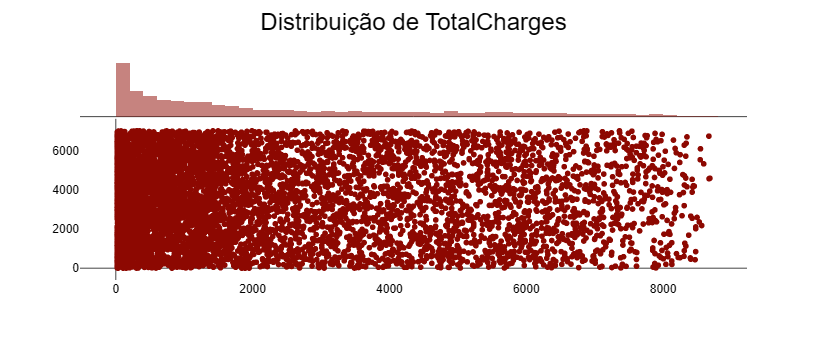

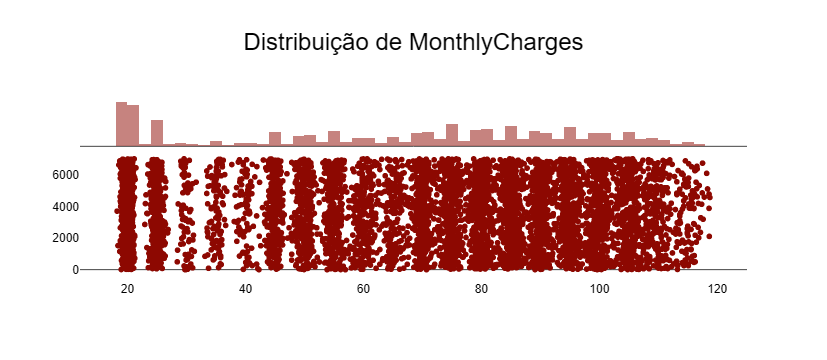

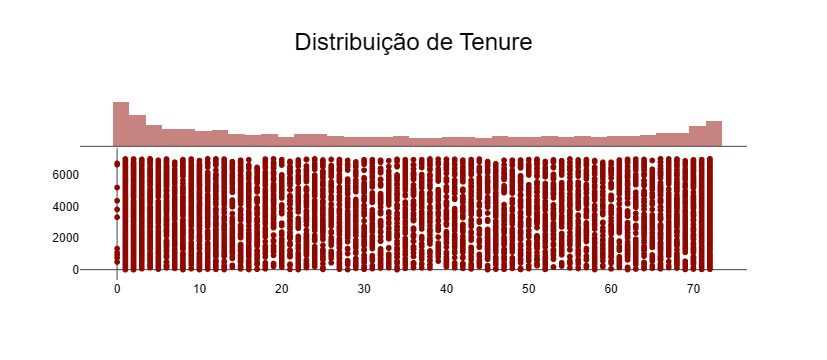

In [7]:
fig_totalcharges = px.scatter(Telco, x='TotalCharges',
                              marginal_x='histogram',
                              labels={'TotalCharges': 'Total Pago'},
                              color_discrete_sequence=['#8d0801'])

fig_totalcharges.update_layout(
    xaxis_title=None,
    yaxis_title=None,
    
    title_text='Distribuição de TotalCharges',  # Define o título
    title_font_size=24,
    title_x=0.5,  # Centraliza o título horizontalmente
    title_xanchor='center',  # Ancla o título ao centro horizontalmente    
)
fig_totalcharges.show()

fig_monthlycharges = px.scatter(Telco, x='MonthlyCharges',
                               title='Distribuição de MonthlyCharges',
                               marginal_x='histogram',  # Adiciona gráfico de densidade
                               labels={'MonthlyCharges': 'Cobrança Mensal'},
                               color_discrete_sequence=['#8d0801'])

fig_monthlycharges.update_layout(
    xaxis_title=None,
    yaxis_title=None,
    
    title_text='Distribuição de MonthlyCharges',  # Define o título
    title_font_size=24,
    title_x=0.5,  # Centraliza o título horizontalmente
    title_xanchor='center',  # Ancla o título ao centro horizontalmente    
)
fig_monthlycharges.show()

fig_tenure = px.scatter(Telco, x='tenure',
                          title='Distribuição de Tenure',
                          marginal_x='histogram',  # Adiciona gráfico de densidade
                          labels={'tenure': 'Tempo de Relacionamento (meses)'},
                          color_discrete_sequence=['#8d0801'])

fig_tenure.update_layout(
    xaxis_title=None,
    yaxis_title=None,
)


fig_tenure.show()

####  Frequências de Variáveis Categóricas

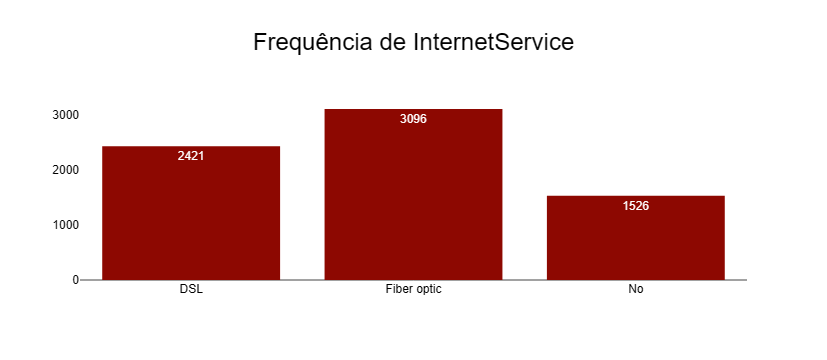

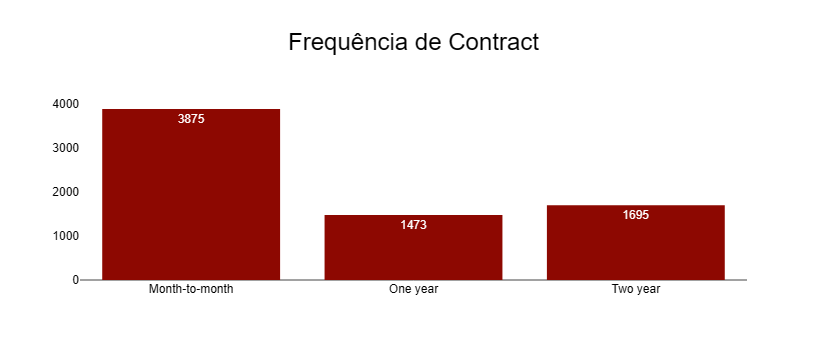

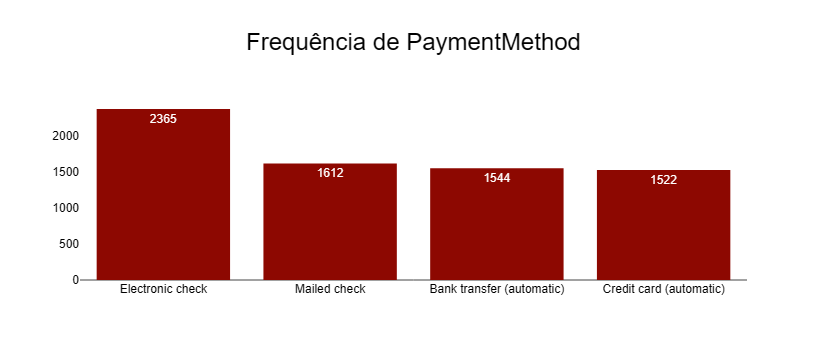

In [8]:
# Gráfico de barras para InternetService
fig_internetservice = px.histogram(Telco, 
                                    x='InternetService', 
                                    title='Frequência de InternetService',
                                    labels={'InternetService': 'Tipo de Serviço de Internet'},text_auto=True,
                                    color_discrete_sequence=['#8d0801'])
fig_internetservice.update_layout(xaxis_title=None,
        yaxis_title=None,)

fig_internetservice.show()

# Gráfico de barras para Contract
fig_contract = px.histogram(Telco, 
                             x='Contract', 
                             title='Frequência de Contract',
                             labels={'Contract': 'Tipo de Contrato'},text_auto=True,
                             color_discrete_sequence=['#8d0801'])
fig_contract.update_layout(xaxis_title=None,
        yaxis_title=None,)

fig_contract.show()

# Gráfico de barras para PaymentMethod
fig_paymentmethod = px.histogram(Telco, 
                                  x='PaymentMethod', 
                                  title='Frequência de PaymentMethod',
                                  labels={'PaymentMethod': 'Método de Pagamento'},text_auto=True,
                                  color_discrete_sequence=['#8d0801'])
fig_paymentmethod.update_layout(xaxis_title=None,
        yaxis_title=None,)

fig_paymentmethod.show()

## Análise Bivariada

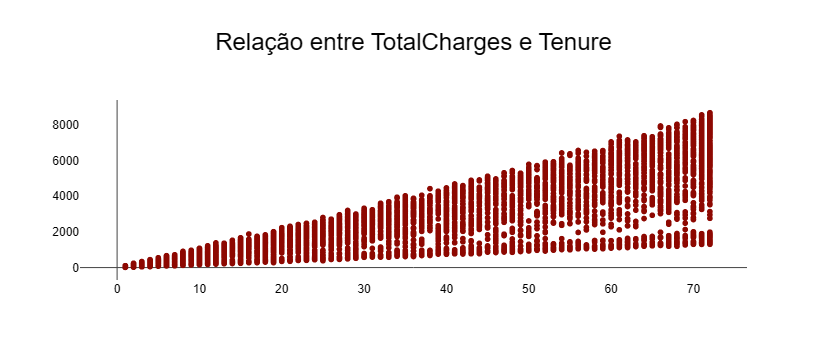

In [9]:
fig_scatter_totalcharges_tenure = px.scatter(Telco, x='tenure', y='TotalCharges',
                                              title='Relação entre TotalCharges e Tenure',
                                              labels={'Tenure': 'Tempo de Relacionamento (Meses)', 'TotalCharges': 'Total Pago'},
                                              color_discrete_sequence=['#8d0801'])
fig_scatter_totalcharges_tenure.update_layout(xaxis_title=None,
        yaxis_title=None,)

fig_scatter_totalcharges_tenure.show()


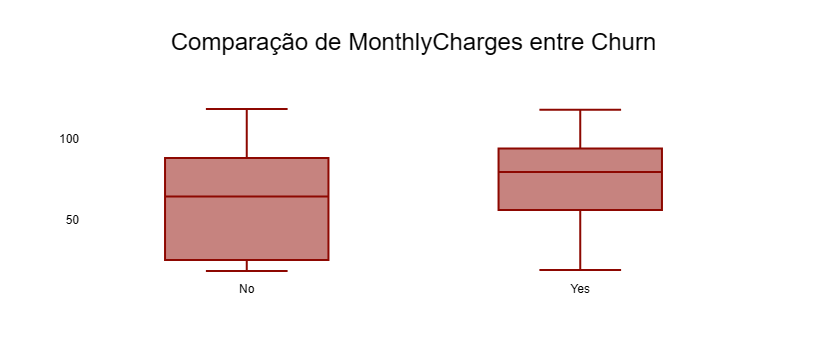

In [10]:
# Box Plot entre MonthlyCharges e Churn
fig_box_monthlycharges_churn = px.box(Telco, x='Churn', y='MonthlyCharges',
                                       title='Comparação de MonthlyCharges entre Churn',
                                       labels={'Churn': 'Cancelamento', 'MonthlyCharges': 'Cobrança Mensal'},
                                       color_discrete_sequence=['#8d0801'])
                                        
fig_box_monthlycharges_churn.update_layout(xaxis_title=None,
        yaxis_title=None,)

fig_box_monthlycharges_churn.show()



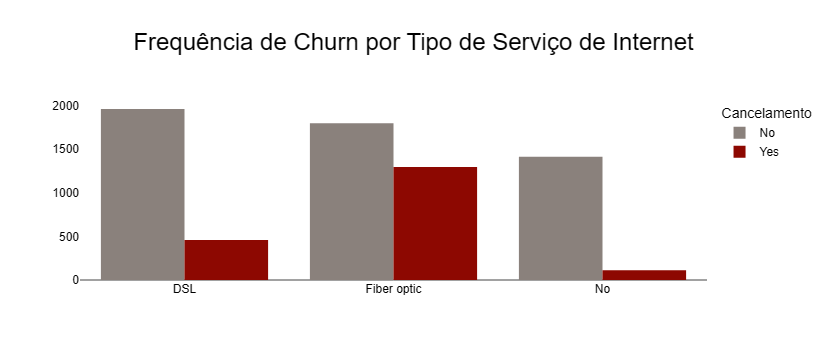

In [11]:

fig_bar_internetservice_churn = px.histogram(Telco, x='InternetService', color='Churn',
                                              title='Frequência de Churn por Tipo de Serviço de Internet',
                                              barmode='group',
                                              labels={'InternetService': 'Tipo de Serviço de Internet', 'Churn': 'Cancelamento'}
                                              )
fig_bar_internetservice_churn.update_layout(xaxis_title=None,
        yaxis_title=None,)

fig_bar_internetservice_churn.show()


In [12]:
def tenure_group(tenure):
    if tenure <= 12:
        return 'Novo Cliente (0-12 meses)'
    elif tenure <= 36:
        return 'Cliente Médio (13-36 meses)'
    elif tenure <= 60:
        return 'Cliente Longo (37-60 meses)'
    else:
        return 'Cliente Fiel (61+ meses)'


Telco['tenure_group_custom'] = Telco['tenure'].apply(tenure_group)


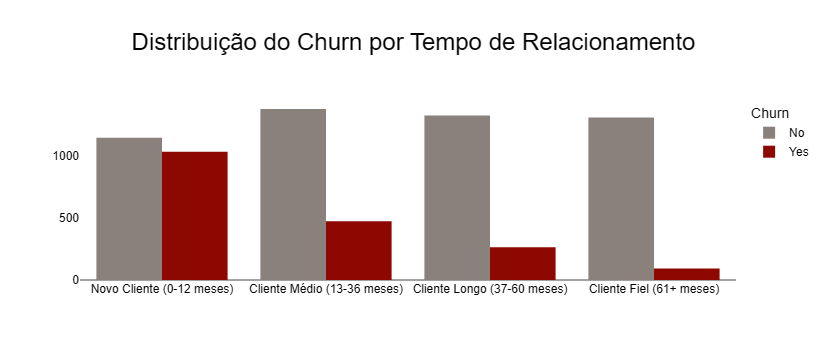

In [13]:

fig = px.histogram(Telco, x='tenure_group_custom', color='Churn', barmode='group',
                   category_orders={'tenure_group_custom': ['Novo Cliente (0-12 meses)', 
                                                           'Cliente Médio (13-36 meses)', 
                                                           'Cliente Longo (37-60 meses)', 
                                                           'Cliente Fiel (61+ meses)']},
                   title="Distribuição do Churn por Tempo de Relacionamento",
                   labels={'tenure_group_custom': 'Grupo de Tempo de Relacionamento', 'count': 'Contagem'},
                   )


fig.update_layout(xaxis_title=None,
                      yaxis_title=None,
                      legend_title='Churn',
                    bargap=0.2
                 )


fig.show()

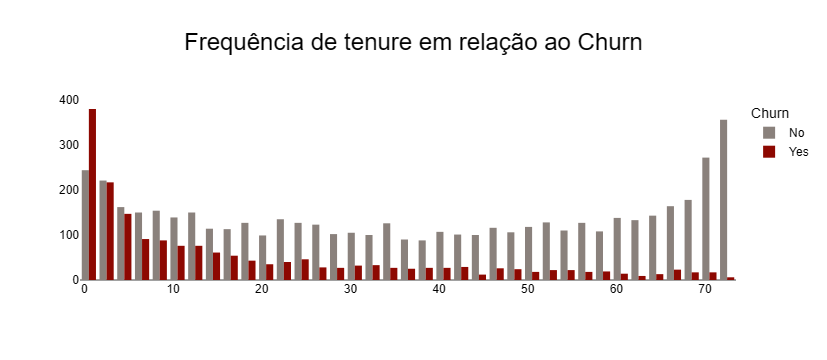

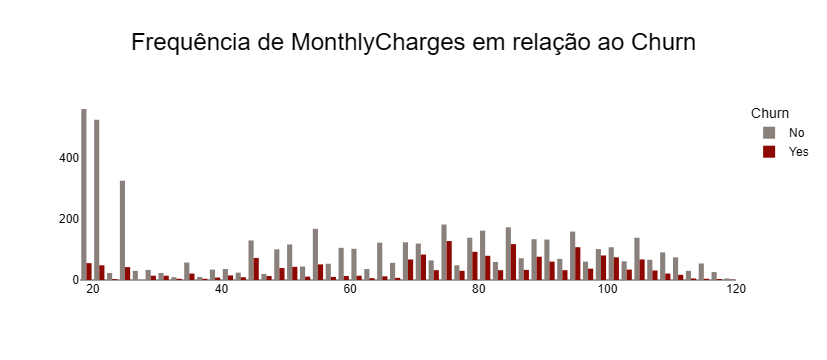

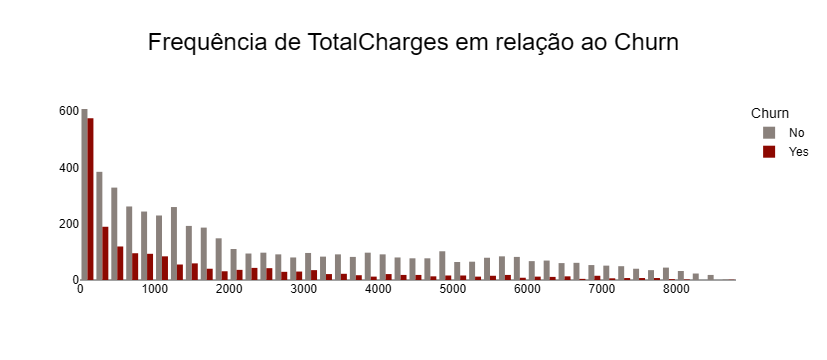

In [14]:
num_list = ['tenure',  'MonthlyCharges', 'TotalCharges']
# Exemplo de análise univariada com Plotly
for feature in num_list:
    fig = px.histogram(Telco, x=feature, color='Churn', barmode='group', 
                       title=f'Frequência de {feature} em relação ao Churn',
                       labels={'Churn': 'Churn (0 = Não, 1 = Sim)', feature: feature})

    fig.update_layout(xaxis_title=None,
                      yaxis_title=None,
                      legend_title='Churn')
    
    fig.show()

# Testes de Hipóteses 

### Visualização do Target

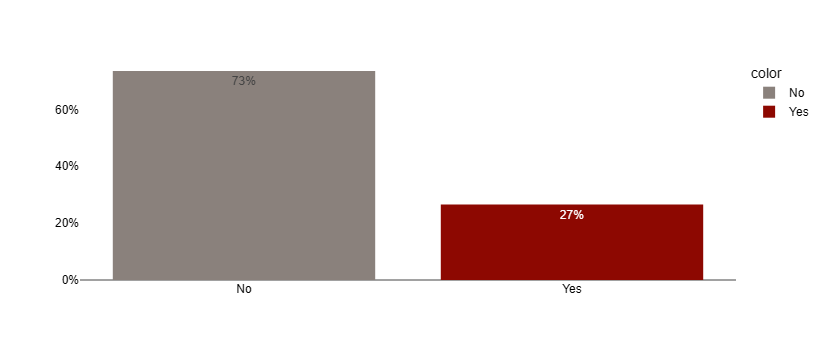

In [15]:
df = Telco['Churn'].value_counts(normalize=True)
fig = px.bar(Telco, x=df.index ,y=df.values,color=df.index,text_auto=True)
fig.update_layout(
    xaxis_title=None,
    yaxis_title=None,    
)

fig.update_yaxes(
    tickformat=".0%",  # Formata o eixo y para exibir como porcentagem
)


color_discrete_sequence=instyle_palette

fig.show()

## Hipóteses

**A MonthlyCharges é uma variável de natureza contínua e com possível assimetria na sua distribuição, então o Teste de Mann-Whitney U nos permitirá determinar se há uma diferença estatisticamente significativa entre as medianas dos dois grupos de clientes, sem fazer suposições de normalidade ou homocedasticidade.**

- $H_0$: O valor da mensalidade não tem efeito significativo na probabilidade de churn.
- $H_1$: Clientes que pagam maiores mensalidades têm maior probabilidade de churn.

In [16]:
from scipy.stats import mannwhitneyu


group_a = Telco[Telco['Churn'] == 'Yes']['MonthlyCharges']
group_b = Telco[Telco['Churn'] == 'No']['MonthlyCharges']
                                                         # maior que o grupo NO
_,p_value = mannwhitneyu(group_a, group_b, alternative = 'greater')

alpha = 0.05

if p_value < alpha:
    print("Rejeitamos H0: Clientes que pagam maiores mensalidades têm maior probabilidade de churn.")
else:
    print("Não rejeitamos H0: O valor da mensalidade não tem efeito significativo na probabilidade de churn.")
    

Rejeitamos H0: Clientes que pagam maiores mensalidades têm maior probabilidade de churn.


---

**Dado que a variável Tenure (tempo de relacionamento) não seguir uma distribuição normal, o Teste de Mann-Whitney U será novamente apropriado para comparar as distribuições entre os dois grupos: clientes que realizaram churn e os que não realizaram.**

- $H_0$: O tempo de relacionamento não tem efeito significativo na probabilidade de churn.
- $H_1$: Clientes com maior tempo de relacionamento têm menor probabilidade de churn.

In [17]:
# Dividir os dados
churned_tenure = Telco[Telco['Churn'] == 'Yes']['tenure'].dropna()
not_churned_tenure = Telco[Telco['Churn'] == 'No']['tenure'].dropna()

# Teste de Mann-Whitney U
stat, p_value = mannwhitneyu(churned_tenure, not_churned_tenure)

alpha = 0.05

if p_value < alpha:
    print("Rejeitamos H0: Clientes com menor tempo de relacionamento têm maior probabilidade de churn.")
else:
    print("Não rejeitamos H0: O tempo de relacionamento não tem efeito significativo na probabilidade de churn.")


Rejeitamos H0: Clientes com menor tempo de relacionamento têm maior probabilidade de churn.


---


**Buscamos entender como o método de pagamento dos clientes se relaciona com a probabilidade de churn (cancelamento de serviços). O método de pagamento pode influenciar a experiência do cliente e sua satisfação geral com os serviços oferecidos.** 

- $H_0$: Rejeitamos H0: Existe uma associação significativa entre o método de pagamento e o churn.
- $H_1$: Não rejeitamos H0: Não há associação significativa entre o método de pagamento e o churn.

In [18]:
# Criando a tabela de contingência
crosstab_payment_churn = pd.crosstab(Telco['PaymentMethod'], Telco['Churn'])

# Realizando o teste qui-quadrado
chi2_stat, p_value, dof, expected = chi2_contingency(crosstab_payment_churn)

# Definindo o nível de significância
alpha = 0.05

# Verificando a hipótese
if p_value < alpha:
    print("Rejeitamos H0: Existe uma associação significativa entre o método de pagamento e o churn.")
else:
    print("Não rejeitamos H0: Não há associação significativa entre o método de pagamento e o churn.")

Rejeitamos H0: Existe uma associação significativa entre o método de pagamento e o churn.


---

# Processamento de Dados

Neste passo, irei realizar uma padronização nos dados das variáveis categóricas, especificamente nas colunas MultipleLines e Serviços Adicionais. As mudanças envolvem a substituição de 682 valores da variável MultipleLines, que atualmente estão categorizados como "No phone service", para "No", e 1.526 valores das variáveis de Serviços Adicionais, que estão com a classificação "No internet service", também para "No".

In [19]:
def replace_values(df):
    df['MultipleLines'] = df['MultipleLines'].replace("No phone service", 'No')

    column_update = ['StreamingMovies', 'StreamingTV', 'TechSupport', 'DeviceProtection', 'OnlineBackup', 'OnlineSecurity']
    replacement_map = {'No internet service': 'No'}

    for col in column_update:
        df[col] = df[col].replace(replacement_map)
    return df

def prepare_data(df):
    df['TotalCharges'] = df['TotalCharges'].replace(' ', np.nan).astype(float)

    binary_columns = ['MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies','Partner',
                     'Dependents','PhoneService','PaperlessBilling']

    for col in binary_columns:
        df[col] = df[col].replace({'Yes': 1, 'No': 0}) 
    return df

Telco['Churn'] = Telco['Churn'].map({'Yes': 1,'No': 0})
Telco['gender'] = Telco['gender'].map({'Male': 1,'Female': 0})

In [20]:
features = Telco.drop(columns=["customerID", "Churn", 'tenure_group_custom'], axis=1).columns.to_list()
target = "Churn"

X = Telco[features]
y = Telco[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

X_train = replace_values(X_train)
X_test = replace_values(X_test)

X_train = prepare_data(X_train)
X_test = prepare_data(X_test)

In [21]:
numerical_features = ['tenure',  'MonthlyCharges', 'TotalCharges']


multi_category = ['Contract','InternetService', 'PaymentMethod']


In [42]:
from sklearn.utils.class_weight import compute_class_weight
# Calcular pesos de classe
class_weights = compute_class_weight("balanced", classes=np.unique(y_train), y=y_train)
weights_dict = {class_label: weight for class_label, weight in zip(np.unique(y_train), class_weights)}
weights_dict

{0: 0.6820697288323188, 1: 1.8731003039513678}

In [30]:
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categoric_transformer = Pipeline([
    ('Oen', OneHotEncoder(handle_unknown='ignore')),
])

preprocessor = ColumnTransformer(transformers=[
    ('num',numeric_transformer, numerical_features),
    ('cat',categoric_transformer, multi_category),
])

-----

-----

In [38]:
def plot_confusion_matrix(y_true, y_pred, title):
    conf_matrix = confusion_matrix(y_true, y_pred)
    labels = ['0', '1'] 
    fig = px.imshow(conf_matrix, 
                    x=labels, y=labels,
                    color_continuous_scale=[[0, '#ffffff'], [1, '#8d0801']],
                    text_auto=True)
    fig.update_xaxes(tickvals=[0, 1], ticktext=labels)
    fig.update_yaxes(tickvals=[0, 1], ticktext=labels)

    fig.update_layout(title_text=title, title_x=0.5)
    fig.show()


def train_and_evaluate(clf, name):
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor), 
        ('classifier', clf)])
    

    pipeline.fit(X_train, y_train)
    
    
    y_pred = pipeline.predict(X_test)
    
    # Avaliação
    print(f"--- Avaliação do {name} ---")
    print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
    print(f"Precision: {precision_score(y_test, y_pred)}")
    print(f"Recall: {recall_score(y_test, y_pred)}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print("\n")
    print("\n" + "-" * 150 + "\n")  
    
    
    # matriz de confusão
    plot_confusion_matrix(y_test, y_pred, f"Matriz de Confusão - {name}")
    
    return pipeline

---

--- Avaliação do XGBoost ---
Accuracy: 0.7851396119261713
Precision: 0.605543710021322
Recall: 0.5135623869801085
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.88      0.86      1560
           1       0.61      0.51      0.56       553

    accuracy                           0.79      2113
   macro avg       0.72      0.70      0.71      2113
weighted avg       0.78      0.79      0.78      2113




------------------------------------------------------------------------------------------------------------------------------------------------------



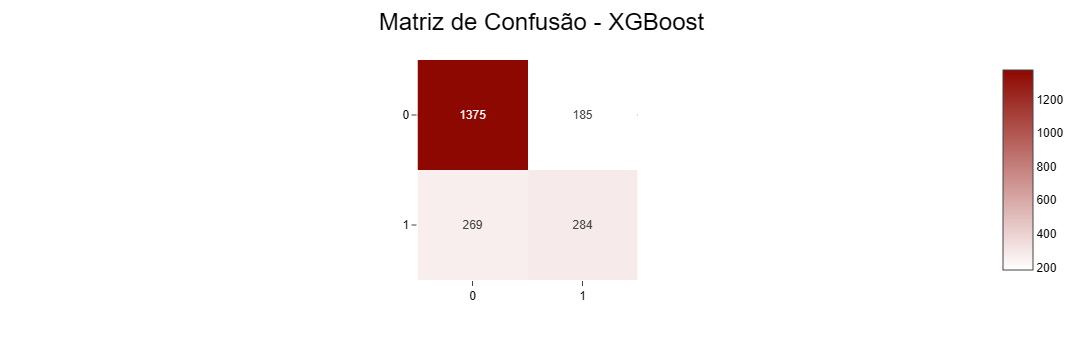

--- Avaliação do Logistic Regression ---
Accuracy: 0.7359204921911974
Precision: 0.49714285714285716
Recall: 0.786618444846293
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.72      0.80      1560
           1       0.50      0.79      0.61       553

    accuracy                           0.74      2113
   macro avg       0.70      0.75      0.70      2113
weighted avg       0.80      0.74      0.75      2113




------------------------------------------------------------------------------------------------------------------------------------------------------



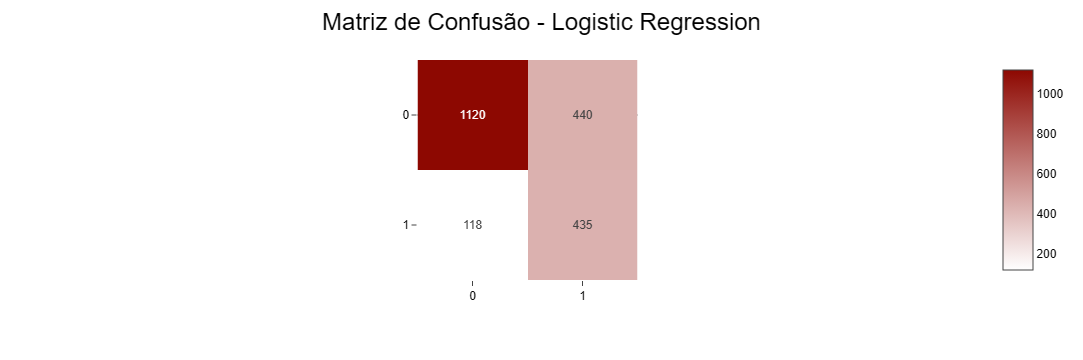

--- Avaliação do Random Forest ---
Accuracy: 0.7766209181258874
Precision: 0.5898004434589801
Recall: 0.4810126582278481
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.88      0.85      1560
           1       0.59      0.48      0.53       553

    accuracy                           0.78      2113
   macro avg       0.71      0.68      0.69      2113
weighted avg       0.77      0.78      0.77      2113




------------------------------------------------------------------------------------------------------------------------------------------------------



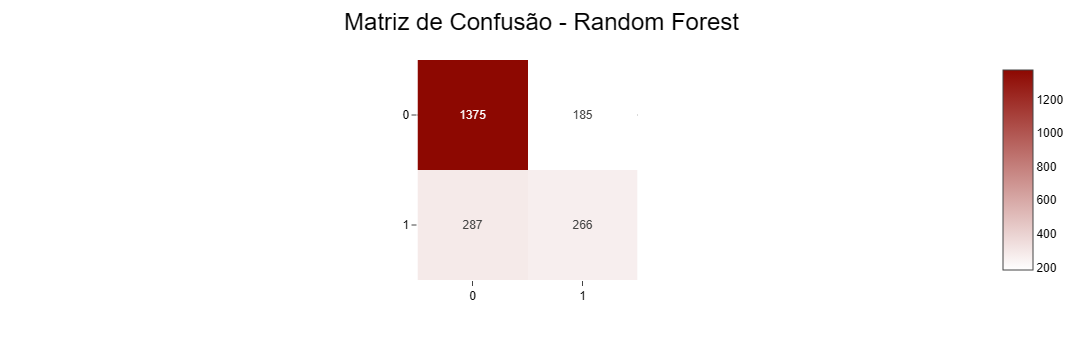

--- Avaliação do AdaBoost ---
Accuracy: 0.7969711310932324
Precision: 0.6319148936170212
Recall: 0.5370705244122965
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.89      0.87      1560
           1       0.63      0.54      0.58       553

    accuracy                           0.80      2113
   macro avg       0.74      0.71      0.72      2113
weighted avg       0.79      0.80      0.79      2113




------------------------------------------------------------------------------------------------------------------------------------------------------



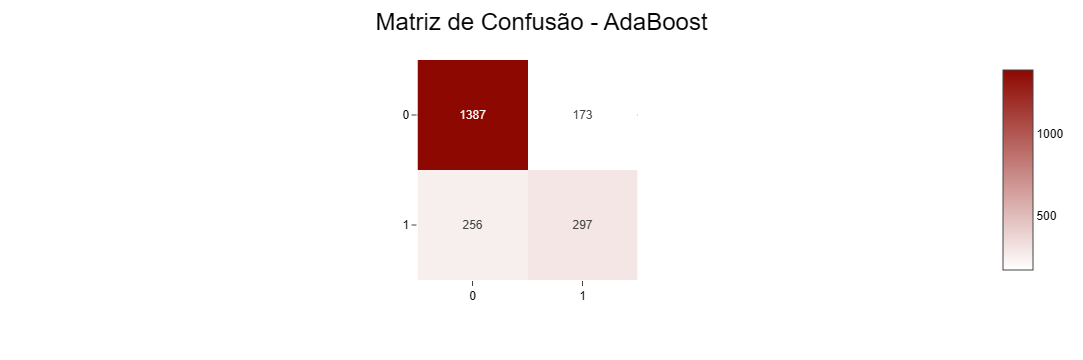

--- Avaliação do Stacking ---
Accuracy: 0.7998106956933271
Precision: 0.6470588235294118
Recall: 0.5171790235081374
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1560
           1       0.65      0.52      0.57       553

    accuracy                           0.80      2113
   macro avg       0.74      0.71      0.72      2113
weighted avg       0.79      0.80      0.79      2113



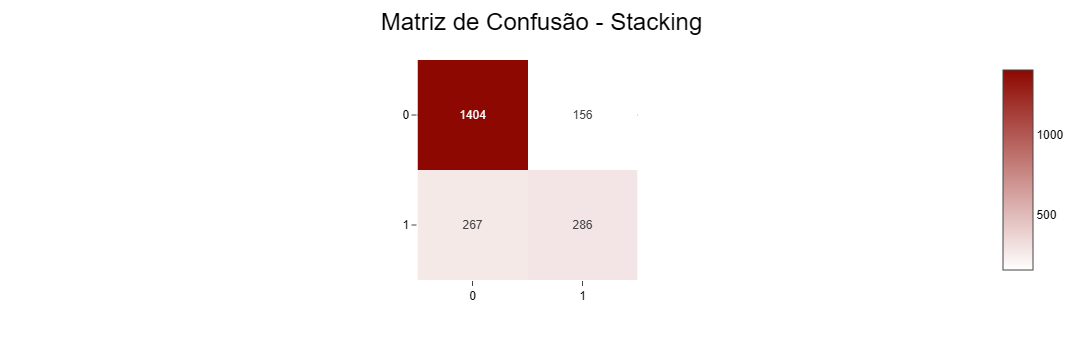

In [43]:
xgb_clf = XGBClassifier(random_state=42)
logistic_clf = LogisticRegression(class_weight=weights_dict,random_state=42)
rf_clf = RandomForestClassifier(class_weight=weights_dict,random_state=42)
ada_clf = AdaBoostClassifier(random_state=42)

pipeline_xgb = train_and_evaluate(xgb_clf, "XGBoost")
pipeline_logistic = train_and_evaluate(logistic_clf, "Logistic Regression")
pipeline_rf = train_and_evaluate(rf_clf, "Random Forest")
pipeline_ada = train_and_evaluate(ada_clf, "AdaBoost")

# Stacking dos modelos
estimators = [
    ('xgb', pipeline_xgb.named_steps['classifier']),
    ('logistic', pipeline_logistic.named_steps['classifier']),
    ('rf', pipeline_rf.named_steps['classifier']),
    ('ada', pipeline_ada.named_steps['classifier'])
]

stacking_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(),  
    cv=5
)


pipeline_stacking = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', stacking_clf)
])


pipeline_stacking.fit(X_train, y_train)
y_pred_stacking = pipeline_stacking.predict(X_test)

# Avaliação final do Stacking
print("--- Avaliação do Stacking ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred_stacking)}")
print(f"Precision: {precision_score(y_test, y_pred_stacking)}")
print(f"Recall: {recall_score(y_test, y_pred_stacking)}")
print("Classification Report:")
print(classification_report(y_test, y_pred_stacking))

# Gerar a matriz de confusão do Stacking com Plotly
plot_confusion_matrix(y_test, y_pred_stacking, "Matriz de Confusão - Stacking")


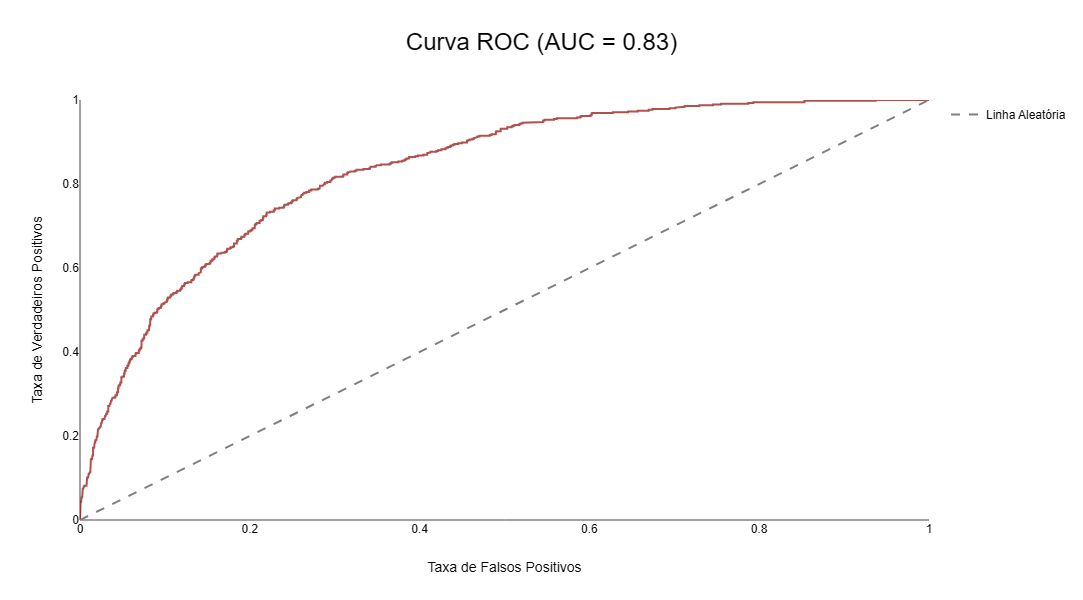

In [40]:
# Cálculo da curva ROC e AUC
y_probs_stacking = pipeline_stacking.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_probs_stacking)
auc = roc_auc_score(y_test, y_probs_stacking)

# Criar um DataFrame para o Plotly Express
roc_data = pd.DataFrame({'FPR': fpr, 'TPR': tpr})

# Plotar a curva ROC sem preenchimento
fig = px.line(roc_data, x='FPR', y='TPR',
              title=f'Curva ROC (AUC = {auc:.2f})',  # Adicionando o AUC ao título
              labels={'FPR': 'Taxa de Falsos Positivos', 'TPR': 'Taxa de Verdadeiros Positivos'},
              line_shape='linear')

# Adicionar a linha de aleatoriedade
fig.add_scatter(x=[0, 1], y=[0, 1], mode='lines',
                 line=dict(color='grey', dash='dash'),
                 name='Linha Aleatória')

# Definir a cor da linha ROC com transparência
fig.data[0].line.color = 'rgba(141, 8, 1, 0.7)'  # Cor #8d0801 com transparência

fig.update_layout(yaxis=dict(range=[0, 1]), xaxis=dict(range=[0, 1]),
                  width=1000,
                  height=600,
                  showlegend=True)

fig.show()

In [51]:
results= []

for thres in np.arange(0.05,1,0.05):

    y_pred = (pipeline_stacking.predict_proba(X_test)[:,1]>thres)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    
    results.append((thres, precision, recall, f1, acc))
    
results_df = pd.DataFrame(results, columns=["thres", "precision", "recall", "f1", "acc"])
results_df

thres  precision    recall        f1       acc
0    0.05   0.337492  0.978300  0.501855  0.491718
1    0.10   0.402546  0.915009  0.559116  0.622338
2    0.15   0.436248  0.866184  0.580254  0.672030
3    0.20   0.481560  0.826401  0.608522  0.721723
4    0.25   0.505239  0.784810  0.614731  0.742546
5    0.30   0.524715  0.748644  0.616990  0.756744
6    0.35   0.543568  0.710669  0.615987  0.768102
7    0.40   0.560748  0.650995  0.602510  0.775201
8    0.45   0.595978  0.589512  0.592727  0.787979
9    0.50   0.647059  0.517179  0.574874  0.799811
10   0.55   0.665789  0.457505  0.542337  0.797918
11   0.60   0.697279  0.370705  0.484061  0.793185
12   0.65   0.731481  0.285714  0.410923  0.785613
13   0.70   0.781818  0.155515  0.259427  0.767629
14   0.75   0.958333  0.041591  0.079723  0.748699
15   0.80   0.000000  0.000000  0.000000  0.738287
16   0.85   0.000000  0.000000  0.000000  0.738287
17   0.90   0.000000  0.000000  0.000000  0.738287
18   0.95   0.000000  0.000000  0.000000  0.738287

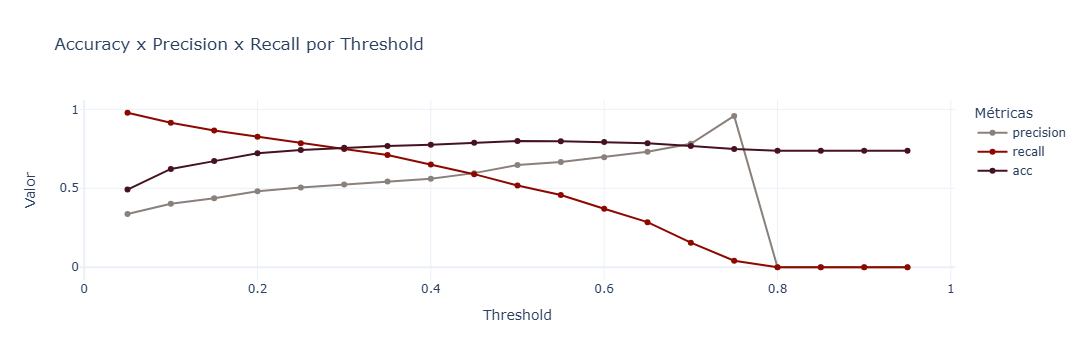

In [47]:
# Primeiro, converta o DataFrame para o formato "long" (long format)
results_long_df = pd.melt(results_df, id_vars="thres", value_vars=["precision", "recall", "acc"],
                          var_name="Métricas", value_name="Valor")

# Crie o gráfico com Plotly Express
fig = px.line(results_long_df, 
              x="thres", 
              y="Valor", 
              color="Métricas", 
              markers=True, 
              title="Accuracy x Precision x Recall por Threshold")

# Configurações de layout adicionais
fig.update_layout(
    xaxis_title="Threshold",
    yaxis_title="Valor",
    template="plotly_white",
    hovermode="x unified"  # Exibe todas as métricas ao passar o mouse
)

# Exibir o gráfico
fig.show()

- Precision: Das Pessoas que o nosso modelo previu que iriam sair, 64% realmente sairam
- Recall: De todos que realmente sairam, nosso modelo previu 51%
- AUC: 0.83 indica que o modelo tem uma boa capacidade de discriminar entre classes positivas e negativas, com uma probabilidade de 83% de classificar corretamente um exemplo positivo em relação a um negativo.

A rotatividade de clientes pode impactar negativamente a lucratividade de uma empresa, tornando crucial a implementação de estratégias eficazes para sua redução. A forma mais eficiente de mitigar a rotatividade é através de um conhecimento profundo sobre os clientes, o que inclui identificar aqueles em risco de deixar a empresa e tomar medidas para aumentar sua satisfação.

No contexto da previsão de rotatividade, a avaliação do modelo Stacking gerou bons resultados, com uma acurácia de 80% e uma AUC de 0.83, indicando que o modelo consegue diferenciar bem entre clientes que permanecerão e os que estão em risco de sair. No entanto, alguns desafios ainda existem. Como melhorar a precisão para a classe de churn (0.65) que é significativamente menor do que a classe de não churn (0.84), sugerindo que o modelo ainda pode melhorar na identificação de clientes que realmente irão sair. Isso é reforçado pelo recall de 0.52 para a classe de churn, indicando que o modelo está deixando de identificar cerca de 48% dos clientes em risco.

Estratégias para reduzir a rotatividade devem focar em melhorar o atendimento ao cliente, oferecendo experiências relevantes e personalizadas que constroem fidelidade. Com base na análise dos dados, além de prever a rotatividade, é possível aplicar essas informações de forma proativa, especialmente ao investigar os motivos pelos quais os clientes deixam a empresa. Essa abordagem, aliada ao uso de um modelo preditivo eficaz, pode ser um caminho sólido para reduzir a rotatividade e aumentar a retenção.

**Etapas do Projeto**

**Análise Exploratória de Dados (EDA):**

- Identificou-se um desbalanceamento entre as classes de churn (clientes que cancelaram e não cancelaram o serviço), sendo uma variável crítica para o ajuste dos modelos.
- Realizou-se uma inspeção da correlação entre variáveis e a remoção de outliers, além de imputação de valores ausentes.

**Pré-processamento:**

- Foram codificadas variáveis categóricas como Contract, InternetService e PaymentMethod.
- Aplicou-se padronização e transformação de variáveis após a divisão dos dados entre treino e teste.
- Variáveis categóricas foram transformadas em 0 e 1, e utilizou-se a estratégia de imputar valores ausentes com a média.

**Modelagem Preditiva:**

- Foram testados diferentes modelos, incluindo XGBoost, Logistic Regression, Random Forest, e AdaBoost.
- Foi utilizado o método de Stacking para combinar previsões de múltiplos modelos e melhorar a performance final.
- Ajustes foram feitos para lidar com o desbalanceamento das classes, incluindo o uso de pesos nas classes e ajuste de limiares de decisão.
  
**Avaliação dos Modelos:**

- Os modelos foram avaliados utilizando métricas como Acurácia, Precisão, Recall e AUC.
- O Stacking apresentou os melhores resultados gerais, com uma Acurácia de 0.80, Precisão de 0.63 e Recall de 0.53 para a classe 1 (churn).

**Conclusões:**

- Stacking foi a técnica que obteve os melhores resultados, combinando as vantagens dos diferentes modelos.
- A regressão logística e o Random Forest também apresentaram desempenhos sólidos, mas com menor equilíbrio entre precisão e recall comparados ao Stacking.
- O desbalanceamento das classes foi tratado de forma eficaz ao ajustar os pesos das classes, resultando em uma melhoria no recall para prever corretamente clientes que deixariam o serviço.

**Possíveis Melhorias:**
- Ajustar ainda mais os parâmetros dos modelos para melhorar a precisão e o recall da classe churn (classe 1).
- Implementar técnicas de undersampling ou oversampling para balancear o dataset sem depender apenas de pesos nas classes.
  

---